<a href="https://colab.research.google.com/github/Mark-McAdam/DS-Unit-2-Linear-Models/blob/master/DS-Unit-2-Linear-Models/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
print(df.shape)


(23040, 21)


In [4]:
print(df.columns)

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')


In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
# the EASE-MENT and APARTMENT_NUMBER columns need to be dropped. 
df = df.drop(columns='EASE-MENT')
df = df.drop(columns='APARTMENT_NUMBER')

In [8]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.


In [0]:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
        (df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000)]

In [10]:
print(df.shape)
# df.head()

(3151, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [11]:
# df.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [12]:
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
BUILDING_CLASS_CATEGORY,3151,1,01 ONE FAMILY DWELLINGS,3151
TAX_CLASS_AT_PRESENT,3151,2,1,3111
BOROUGH,3151,5,4,1580
NEIGHBORHOOD,3151,6,OTHER,2990
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185
SALE_DATE,3151,91,01/31/2019,78
LAND_SQUARE_FEET,3151,1035,"4,000",289
ADDRESS,3151,3135,57 CHESTNUT STREET,2


In [13]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# land square feet is an object as current. Has a comma and str format 
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '')
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(int)

In [15]:
df['LAND_SQUARE_FEET']

44       6800
61       4000
78       3500
108      4000
111      1710
         ... 
23029    3300
23031    2400
23032    4000
23033    2500
23035    1800
Name: LAND_SQUARE_FEET, Length: 3151, dtype: int64

# Do train/test split.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.


In [16]:
# first convert the time to an appropriate date time format 
# df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['SALE_DATE']

44       01/01/2019
61       01/01/2019
78       01/02/2019
108      01/02/2019
111      01/02/2019
            ...    
23029    04/30/2019
23031    04/30/2019
23032    04/30/2019
23033    04/30/2019
23035    04/30/2019
Name: SALE_DATE, Length: 3151, dtype: object

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [0]:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
        (df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000)]

In [0]:
# get rid of all the unneccesary columns from the data frame before we split it
# BUILDING_CLASS_CATEGORY is redundant now. 
df = df.drop(columns='BUILDING_CLASS_CATEGORY')

# TAX_CLASS_AT_TIME_OF_SALE is all same value 
df = df.drop(columns='TAX_CLASS_AT_TIME_OF_SALE')


In [0]:
cutoff = pd.to_datetime('2019-03-31')
train = df[df['SALE_DATE'] <= cutoff]
test = df[df['SALE_DATE'] > cutoff]

In [21]:
# train.head()

<bound method NDFrame.head of       BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
44          3        OTHER  ...     550000 2019-01-01
61          4        OTHER  ...     200000 2019-01-01
78          2        OTHER  ...     810000 2019-01-02
108         3        OTHER  ...     125000 2019-01-02
111         3        OTHER  ...     620000 2019-01-02
...       ...          ...  ...        ...        ...
18129       5        OTHER  ...     330000 2019-03-29
18130       5        OTHER  ...     690000 2019-03-29
18132       5        OTHER  ...     610949 2019-03-29
18134       5        OTHER  ...     520000 2019-03-29
18147       4        OTHER  ...     104000 2019-03-30

[2507 rows x 17 columns]>

In [22]:
# test.head()

<bound method NDFrame.head of       BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
18235       2        OTHER  ...     895000 2019-04-01
18239       2        OTHER  ...     253500 2019-04-01
18244       3        OTHER  ...    1300000 2019-04-01
18280       3        OTHER  ...     789000 2019-04-01
18285       3        OTHER  ...     525000 2019-04-01
...       ...          ...  ...        ...        ...
23029       4        OTHER  ...     635000 2019-04-30
23031       4        OTHER  ...     514000 2019-04-30
23032       4        OTHER  ...     635000 2019-04-30
23033       4        OTHER  ...     545000 2019-04-30
23035       4        OTHER  ...     510000 2019-04-30

[644 rows x 17 columns]>

# Do one-hot encoding
- [ ] Do one-hot encoding of categorical features.



In [23]:
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
TAX_CLASS_AT_PRESENT,3151,2,1,3111,NaT,NaT
BOROUGH,3151,5,4,1580,NaT,NaT
NEIGHBORHOOD,3151,6,OTHER,2990,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185,NaT,NaT
SALE_DATE,3151,91,2019-01-31 00:00:00,78,2019-01-01,2019-04-30
ADDRESS,3151,3135,57 CHESTNUT STREET,2,NaT,NaT


In [24]:
df.describe(include='number')

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3.151000e+03
mean,6917.976515,75.981593,11027.219613,0.987623,0.015868,1.003491,3112.117423,1470.306887,1943.694700,6.285601e+05
std,3963.326705,161.089514,482.875284,0.113414,0.127499,0.171789,1790.055434,586.339200,26.676786,2.929904e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.040000e+05
25%,4016.000000,21.000000,10461.000000,1.000000,0.000000,1.000000,2000.000000,1144.000000,1925.000000,4.475000e+05
50%,6301.000000,42.000000,11235.000000,1.000000,0.000000,1.000000,2542.000000,1360.000000,1938.000000,5.680000e+05
75%,10208.500000,69.000000,11413.000000,1.000000,0.000000,1.000000,4000.000000,1683.000000,1955.000000,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,18906.000000,7875.000000,2018.000000,1.955000e+06


In [0]:
# df.isnull().sum()

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'ADDRESS']
features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)

In [0]:
X_train = encoder.fit_transform(X_train)

In [0]:
X_test = encoder.transform(X_test)

In [58]:
# X_train

BOROUGH_3                              int64
BOROUGH_4                              int64
BOROUGH_2                              int64
BOROUGH_5                              int64
BOROUGH_1                              int64
NEIGHBORHOOD_OTHER                     int64
NEIGHBORHOOD_FLUSHING-NORTH            int64
NEIGHBORHOOD_BEDFORD STUYVESANT        int64
NEIGHBORHOOD_FOREST HILLS              int64
NEIGHBORHOOD_BOROUGH PARK              int64
NEIGHBORHOOD_ASTORIA                   int64
TAX_CLASS_AT_PRESENT_1                 int64
TAX_CLASS_AT_PRESENT_1D                int64
BLOCK                                  int64
LOT                                    int64
BUILDING_CLASS_AT_PRESENT_A9           int64
BUILDING_CLASS_AT_PRESENT_A1           int64
BUILDING_CLASS_AT_PRESENT_A5           int64
BUILDING_CLASS_AT_PRESENT_A0           int64
BUILDING_CLASS_AT_PRESENT_A2           int64
BUILDING_CLASS_AT_PRESENT_A3           int64
BUILDING_CLASS_AT_PRESENT_S1           int64
BUILDING_C

In [0]:
# X_test

# feature selection with `SelectKBest`
 - [ ] Do feature selection with `SelectKBest`.


In [0]:
import warnings
from sklearn.feature_selection import SelectKBest, f_regression

In [0]:
warnings.filterwarnings('ignore')

In [0]:
selector = SelectKBest(score_func=f_regression, k =15)

In [0]:
X_train_selected = selector.fit_transform(X_train, y_train)

In [0]:
X_test_selected = selector.transform(X_test)

In [37]:
X_train_selected.shape, X_test_selected.shape

((2507, 15), (644, 15))

## Which features were selected SelecKBest

In [0]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

In [39]:
print('Features Selected:')
for name in selected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


In [40]:
print('\n')
print('Features not selected:')
for name in unselected_names:
  print(name)



Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0


In [41]:
len(X_train.columns)

46

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [43]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $183,641 

2 features
Test Mean Absolute Error: $179,555 

3 features
Test Mean Absolute Error: $179,291 

4 features
Test Mean Absolute Error: $179,291 

5 features
Test Mean Absolute Error: $170,483 

6 features
Test Mean Absolute Error: $169,982 

7 features
Test Mean Absolute Error: $168,140 

8 features
Test Mean Absolute Error: $168,245 

9 features
Test Mean Absolute Error: $167,855 

10 features
Test Mean Absolute Error: $164,737 

11 features
Test Mean Absolute Error: $165,346 

12 features
Test Mean Absolute Error: $164,860 

13 features
Test Mean Absolute Error: $155,159 

14 features
Test Mean Absolute Error: $156,541 

15 features
Test Mean Absolute Error: $156,572 

16 features
Test Mean Absolute Error: $156,573 

17 features
Test Mean Absolute Error: $156,394 

18 features
Test Mean Absolute Error: $156,394 

19 features
Test Mean Absolute Error: $156,255 

20 features
Test Mean Absolute Error: $156,255 

21 features
Test Mean Absolut

#29 features
##Test Mean Absolute Error: $153,863 
### Using KBest and Linear Regression 

- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)


In [0]:
from IPython.display import display, HTML
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
%matplotlib inline

ridge = RidgeCV(alphas=alphas, normalize=True)


In [0]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

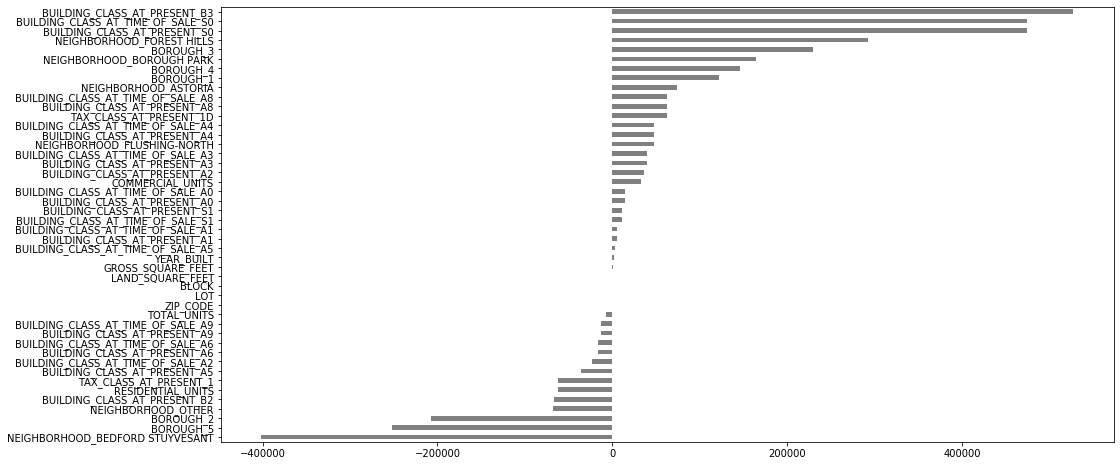

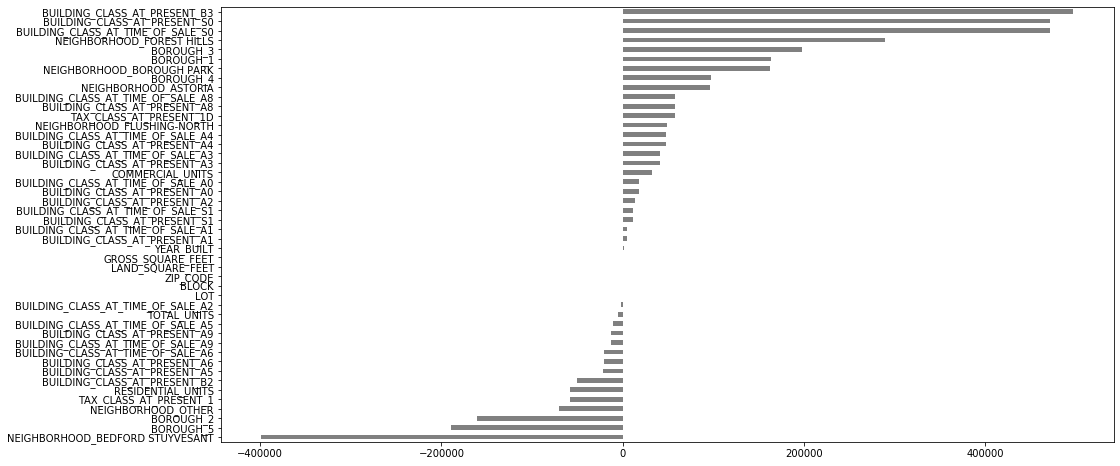

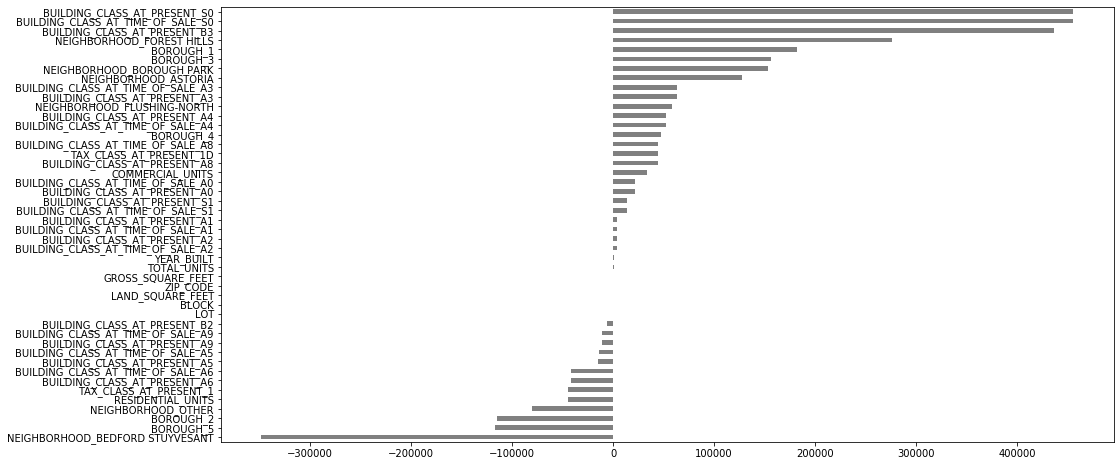

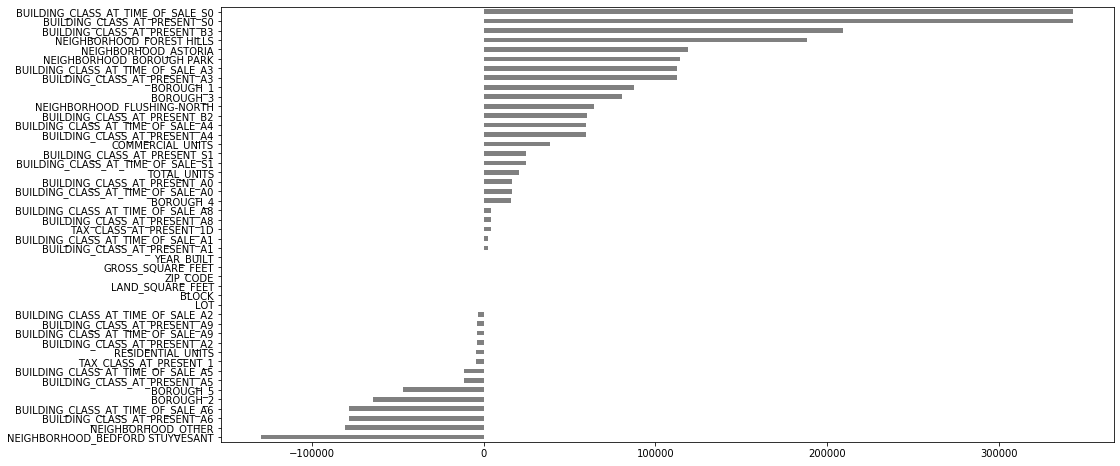

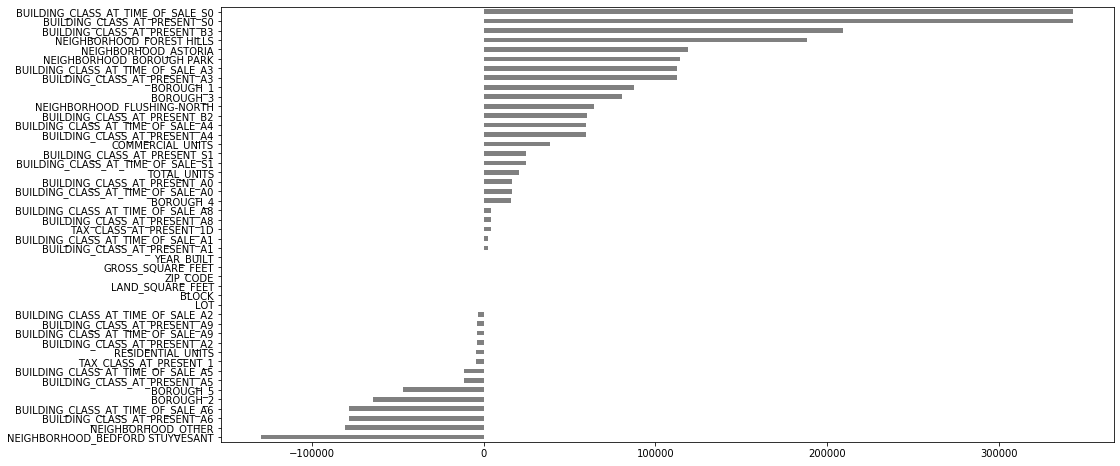

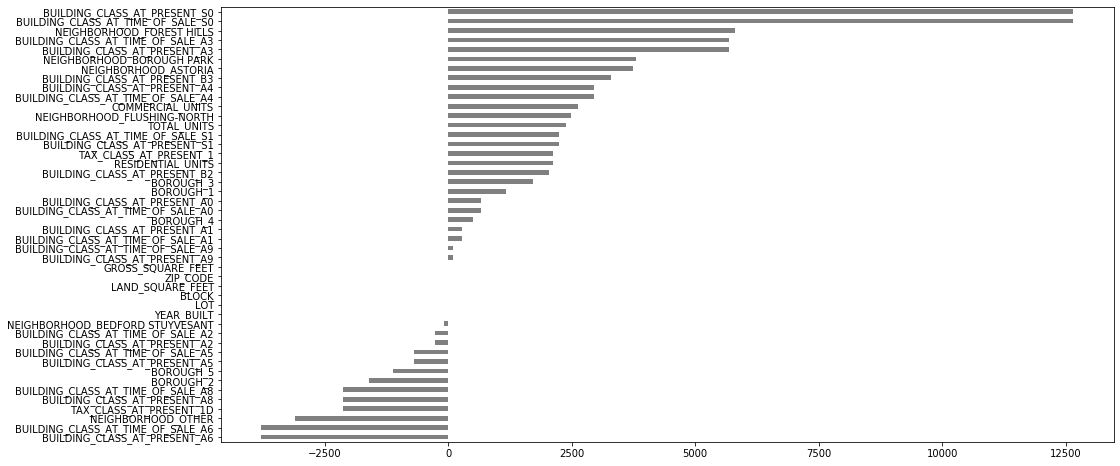

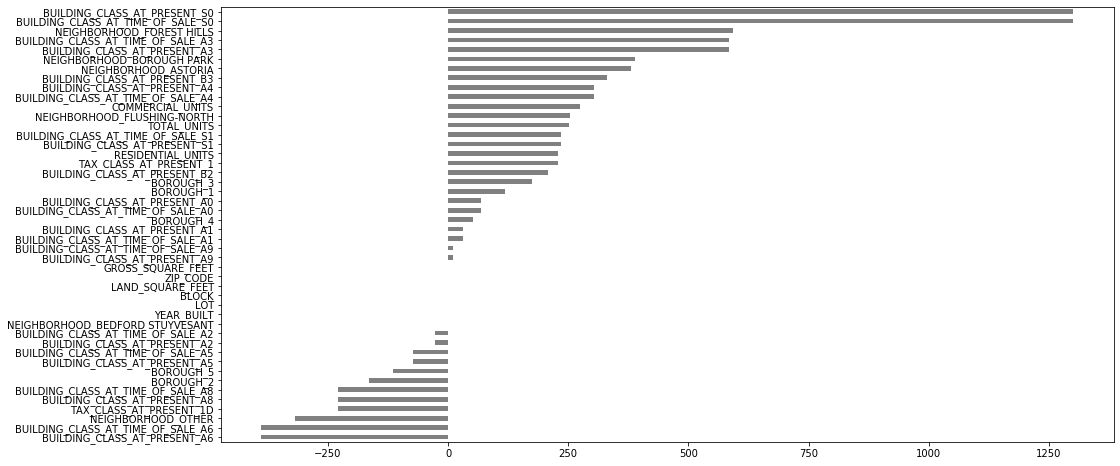

In [57]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    # plt.xlim(-10000,10000)
    plt.show()

# Ridge Regression, with alpha=0.1
# Test Mean Absolute Error: $155,470
  ridge regression non cv

###do feature scaling beforehand 
— use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

In [0]:
# fit transform with the train set

In [0]:
# transform with the test set 

In [0]:
scaler = preprocessing.StandardScaler().fit(X_train)
>>> scaler
StandardScaler()

>>> scaler.mean_
array([1. ..., 0. ..., 0.33...])

>>> scaler.scale_
array([0.81..., 0.81..., 1.24...])

>>> scaler.transform(X_train)
array([[ 0.  ..., -1.22...,  1.33...],
       [ 1.22...,  0.  ..., -0.26...],
       [-1.22...,  1.22..., -1.06...]])
The scaler instance can then be used on new data to transform it the same way it did on the training set:

>>>
>>> X_test = [[-1., 1., 0.]]
>>> scaler.transform(X_test)
array([[-2.44...,  1.22..., -0.26...]])

- [ ] Get mean absolute error for the test set.


- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

![alt text](https://)